# NOTEBOOK FOR DEVELOPING THE SMA CROSS OVER STRATEGY

## LEFT OFF AT TP/SL/SMA SIGNALING 

UPDATING THIS NOTEBOOK TO THE MOST RECENT IMPLEMENTATION FROM yfinance_exploration.ipynb

In [89]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [90]:
# Strategy parameters
ticker = "NVDA"
short_window = 20
long_window = 50
take_profit_pct = 0.55
stop_loss_pct = 0.05
initial_capital = 1
years = 5

In [91]:
# 1. Download Data and format
end_date = datetime.today()
start_date = end_date - timedelta(days=365 * years)

df_sma_v1 = yf.download(ticker, start=start_date, end=end_date)

df_sma_v1.columns = df_sma_v1.columns.get_level_values(0)

C:\Users\nic\AppData\Local\Temp\ipykernel_9036\864286611.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_sma_v1 = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [92]:
# 2. Calculate SMA + signal
df_sma_v1[f'SMA_{short_window}'] = df_sma_v1['Close'].rolling(window=short_window).mean()
df_sma_v1[f'SMA_{long_window}'] = df_sma_v1['Close'].rolling(window=long_window).mean()

# Signal: 1 for long entry, -1 for short, 0 otherwise
df_sma_v1['Signal'] = 0
df_sma_v1.loc[df_sma_v1[f'SMA_{short_window}'] > df_sma_v1[f'SMA_{long_window}'], 'Signal'] = 1
df_sma_v1.loc[df_sma_v1[f'SMA_{short_window}'] < df_sma_v1[f'SMA_{long_window}'], 'Signal'] = -1

# Drop early NaNs because data is only valid after enough days have passed
df_sma_v1 = df_sma_v1.dropna().copy()

In [93]:
# 3. TP/SL logic
tp_sl_signals = []
in_trade = False
entry_price = 0

for i in range(len(df_sma_v1)):
    
    close_price = df_sma_v1['Close'].iloc[i]
    
    if not in_trade:
        
        if df_sma_v1['Signal'].iloc[i] == 1:
            


            entry_price = close_price
            in_trade = True
            tp_sl_signals.append(1)
        
        else:
            
            tp_sl_signals.append(0)
    else:
        current_return = (close_price - entry_price) / entry_price
        
        sma_exit = df_sma_v1['Signal'].iloc[i] == 0
        
        if current_return >= take_profit_pct or current_return <= -stop_loss_pct or sma_exit:
            
            in_trade = False
            tp_sl_signals.append(0)
        
        else:
            
            tp_sl_signals.append(1)

df_sma_v1['TP_SL_Signal'] = tp_sl_signals


In [94]:
# 4. Returns
df_sma_v1['Market Return'] = df_sma_v1['Close'].pct_change()
df_sma_v1['Strategy Return'] = df_sma_v1['Market Return'] * df_sma_v1['TP_SL_Signal'].shift(1).fillna(0)
df_sma_v1['Cumulative Market Return'] = (1 + df_sma_v1['Market Return'].fillna(0)).cumprod()
df_sma_v1['Cumulative Strategy Return'] = (1 + df_sma_v1['Strategy Return']).cumprod()

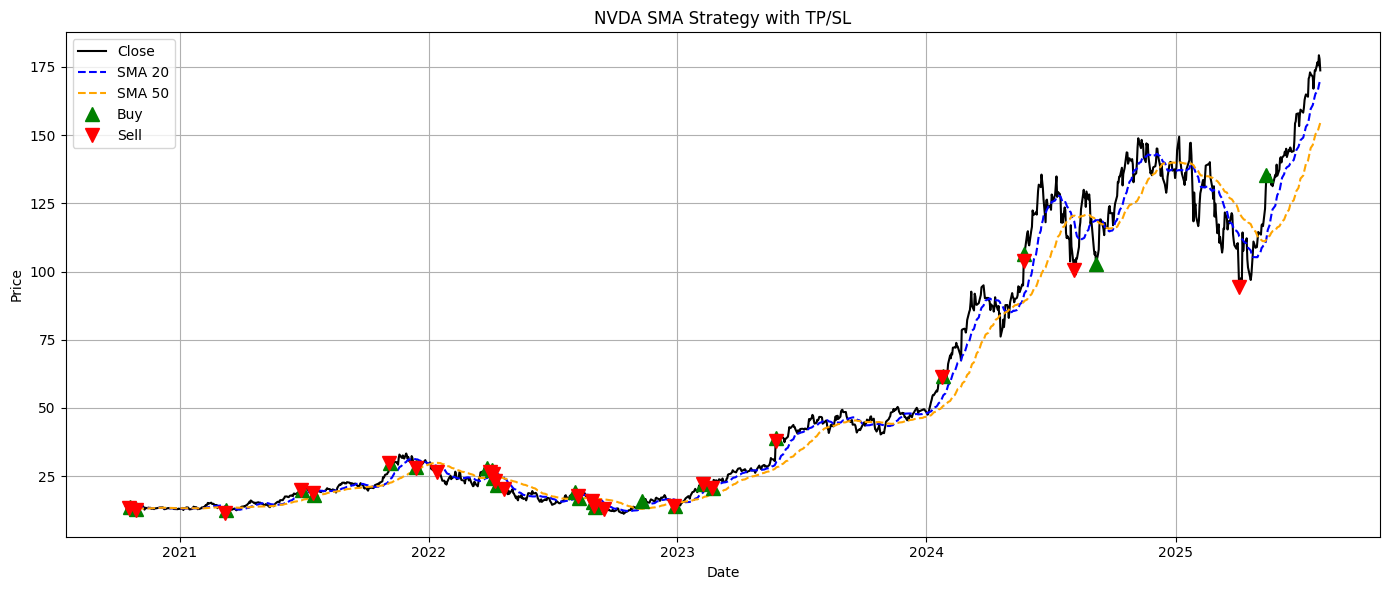

In [95]:
# 5. Price Chart + Signals
plt.figure(figsize=(14, 6))

# Plot closing price
plt.plot(df_sma_v1['Close'], label='Close', color='black')

# Plot dynamic SMAs
plt.plot(df_sma_v1[f'SMA_{short_window}'], label=f'SMA {short_window}', linestyle='--', color='blue')
plt.plot(df_sma_v1[f'SMA_{long_window}'], label=f'SMA {long_window}', linestyle='--', color='orange')

# Identify entry and exit points
buy_signals = df_sma_v1[df_sma_v1['TP_SL_Signal'].diff() == 1]
sell_signals = df_sma_v1[df_sma_v1['TP_SL_Signal'].diff() == -1]

# Plot signal markers
plt.plot(buy_signals.index, buy_signals['Close'], '^', markersize=10, color='green', label='Buy')
plt.plot(sell_signals.index, sell_signals['Close'], 'v', markersize=10, color='red', label='Sell')

# Add chart formatting
plt.title(f"{ticker} SMA Strategy with TP/SL")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


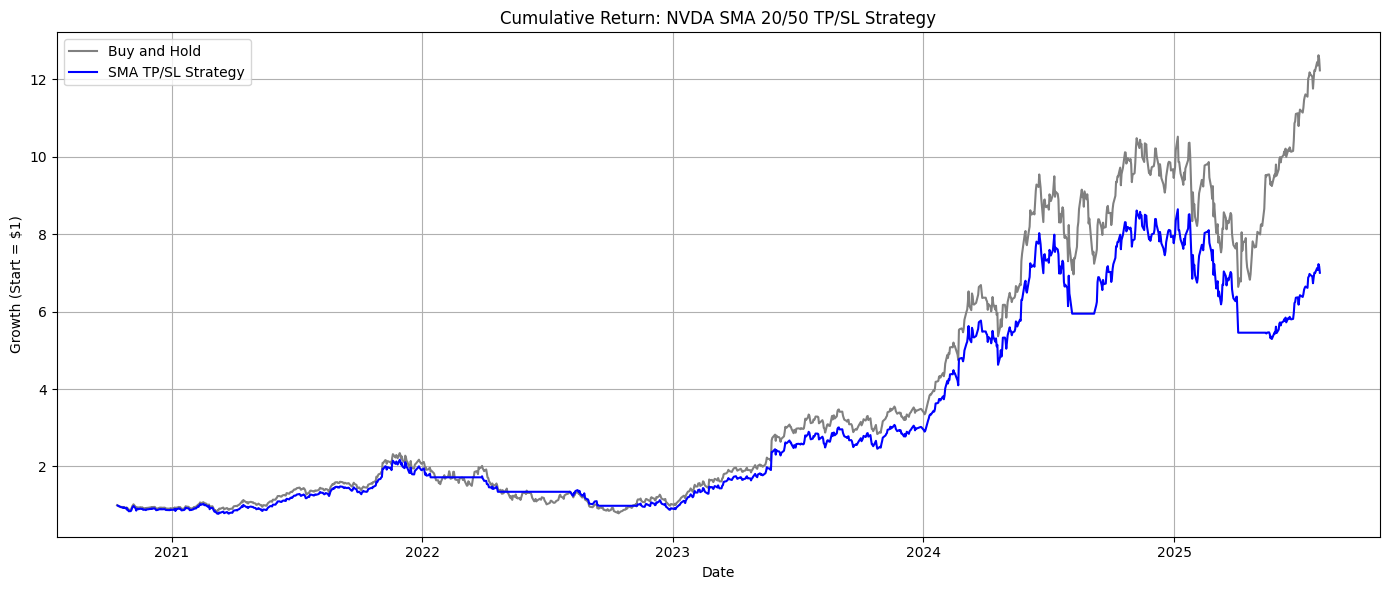

In [96]:
# 6. Cumulative Return Chart
plt.figure(figsize=(14,6))
plt.plot(df_sma_v1['Cumulative Market Return'], label='Buy and Hold', color='gray')
plt.plot(df_sma_v1['Cumulative Strategy Return'], label='SMA TP/SL Strategy', color='blue')
plt.title(f'Cumulative Return: {ticker} SMA {short_window}/{long_window} TP/SL Strategy')
plt.xlabel('Date')
plt.ylabel('Growth (Start = $1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [97]:
print("SMA Trades:", df_sma_v1['TP_SL_Signal'].diff().abs().sum() / 2)


SMA Trades: 24.0


In [98]:
tp_values = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
results_sma = []

df_sma_v1.reset_index(drop=True, inplace=True)

for tp in tp_values:
    df = df_sma_v1.copy()
    df.reset_index(drop=True, inplace=True)  # Ensure consistent indexing
    signals = []
    in_trade = False
    entry_price = 0
    trade_returns = []

    for i in range(len(df)):
        close = df['Close'].iloc[i]
        sma_short = df[f'SMA_{short_window}'].iloc[i]
        sma_long = df[f'SMA_{long_window}'].iloc[i]

        if not in_trade:
            if sma_short > sma_long:
                entry_price = close
                in_trade = True
                signals.append(1)
            else:
                signals.append(0)
        else:
            ret = (close - entry_price) / entry_price
            exit_signal = sma_short < sma_long

            if ret >= tp or ret <= -stop_loss_pct or exit_signal:
                trade_returns.append(ret)
                in_trade = False
                signals.append(0)
            else:
                signals.append(1)

    df['TP_SL_Signal'] = signals
    df['Market Return'] = df['Close'].pct_change()
    df['Strategy Return'] = df['Market Return'] * df['TP_SL_Signal'].shift(1).fillna(0)
    df['Cumulative Strategy Return'] = (1 + df['Strategy Return'].fillna(0)).cumprod()

    trade_returns = pd.Series(trade_returns)
    total_trades = len(trade_returns)
    win_rate = (trade_returns > 0).sum() / total_trades if total_trades else 0
    avg_win = trade_returns[trade_returns > 0].mean() if total_trades else 0
    avg_loss = trade_returns[trade_returns < 0].mean() if total_trades else 0
    profit_factor = abs(trade_returns[trade_returns > 0].sum() / trade_returns[trade_returns < 0].sum()) if (trade_returns < 0).sum() != 0 else None
    final_return = df['Cumulative Strategy Return'].iloc[-1]

    results_sma.append({
        'TP (%)': int(tp * 100),
        'Total Trades': total_trades,
        'Win Rate (%)': round(win_rate * 100, 2),
        'Avg Win (%)': round(avg_win * 100, 2),
        'Avg Loss (%)': round(avg_loss * 100, 2),
        'Profit Factor': round(profit_factor, 2) if profit_factor else None,
        'Final Return (x)': round(final_return, 2)
    })

results_sma_df = pd.DataFrame(results_sma)
display(results_sma_df)


,TP (%),Total Trades,Win Rate (%),Avg Win (%),Avg Loss (%),Profit Factor,Final Return (x)
0,5,121,59.50,6.55,-6.51,1.48,3.45
1,10,89,47.19,10.70,-6.31,1.52,3.23
2,15,63,44.44,13.97,-6.18,1.81,4.31
3,20,49,44.90,15.72,-6.73,1.90,3.66
4,25,49,40.82,18.49,-6.47,1.97,3.81
5,30,44,40.91,18.96,-6.71,1.96,3.26
6,35,40,42.50,18.80,-7.06,1.97,3.85
7,40,39,41.03,19.57,-6.69,2.03,3.93
8,45,34,47.06,18.57,-6.65,2.48,4.80
9,50,35,45.71,19.32,-6.62,2.46,4.73


In [99]:
# Step 1: Find best TP from sweep table
best_tp_row = results_sma_df.loc[results_sma_df['Final Return (x)'].idxmax()]
best_tp = best_tp_row['TP (%)'] / 100

# Step 2: Reapply best TP strategy to df_sma_v1
signals = []
in_trade = False
entry_price = 0

for i in range(len(df_sma_v1)):
    close = df_sma_v1['Close'].iloc[i]
    sma_short = df_sma_v1[f'SMA_{short_window}'].iloc[i]
    sma_long = df_sma_v1[f'SMA_{long_window}'].iloc[i]

    if not in_trade:
        if sma_short > sma_long:
            entry_price = close
            in_trade = True
            signals.append(1)
        else:
            signals.append(0)
    else:
        ret = (close - entry_price) / entry_price
        exit_signal = sma_short < sma_long

        if ret >= best_tp or ret <= -stop_loss_pct or exit_signal:
            in_trade = False
            signals.append(0)
        else:
            signals.append(1)

df_sma_v1['TP_SL_Signal'] = signals
df_sma_v1['Market Return'] = df_sma_v1['Close'].pct_change()
df_sma_v1['Strategy Return'] = df_sma_v1['Market Return'] * df_sma_v1['TP_SL_Signal'].shift(1).fillna(0)
df_sma_v1['Cumulative Strategy Return'] = (1 + df_sma_v1['Strategy Return']).cumprod()


In [100]:
# Reset the original df before reuse
df_best = df_sma_v1.copy().reset_index(drop=True)

# Re-run logic with best TP
signals = []
in_trade = False
entry_price = 0

for i in range(len(df_best)):
    close = df_best['Close'].iloc[i]
    sma_short = df_best[f'SMA_{short_window}'].iloc[i]
    sma_long = df_best[f'SMA_{long_window}'].iloc[i]

    if not in_trade:
        if sma_short > sma_long:
            entry_price = close
            in_trade = True
            signals.append(1)
        else:
            signals.append(0)
    else:
        ret = (close - entry_price) / entry_price
        exit_signal = sma_short < sma_long

        if ret >= best_tp or ret <= -stop_loss_pct or exit_signal:
            in_trade = False
            signals.append(0)
        else:
            signals.append(1)

# Apply strategy results to df_best
df_best['TP_SL_Signal'] = signals
df_best['Market Return'] = df_best['Close'].pct_change()
df_best['Strategy Return'] = df_best['Market Return'] * df_best['TP_SL_Signal'].shift(1).fillna(0)
df_best['Cumulative Strategy Return'] = (1 + df_best['Strategy Return']).cumprod()



In [101]:
print(f"Reapplied TP: {best_tp * 100}%")
print(f"Final Strategy Return (x): {df_sma_v1['Cumulative Strategy Return'].iloc[-1]:.2f}")


Reapplied TP: 45.0%
Final Strategy Return (x): 4.80


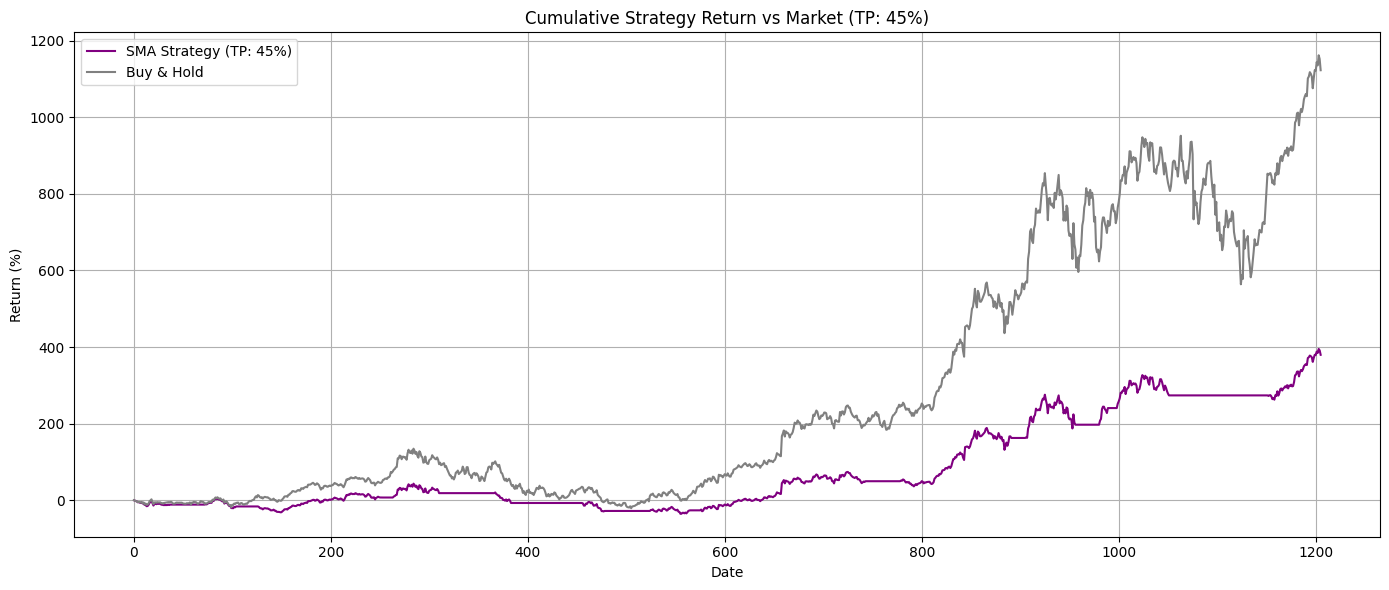

In [102]:
plt.figure(figsize=(14, 6))
plt.plot((df_best['Cumulative Strategy Return'] - 1) * 100, label=f"SMA Strategy (TP: {int(best_tp*100)}%)", color='purple')
plt.plot((df_best['Close'].pct_change().fillna(0) + 1).cumprod().sub(1) * 100, label='Buy & Hold', color='gray')
plt.title(f"Cumulative Strategy Return vs Market (TP: {int(best_tp*100)}%)")
plt.xlabel("Date")
plt.ylabel("Return (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

